In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
print('Scanpy version:', sc.__version__)

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

Scanpy version: 1.9.1


/var/folders/fr/z238tpm931s466144gcdpdj40000gn/T/ipykernel_7751/1644390834.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# !pip install scperturb --upgrade
# from scperturb import *

In [2]:
import sys
sys.path.append("..")
%reload_ext autoreload
%autoreload 2
from src.scperturb import *

# Prepare the data

In [19]:
# !wget https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad
adata = sc.read('DatlingerBock2021.h5ad')
adata

AnnData object with n_obs × n_vars = 39194 × 25904
    obs: 'sample', 'cell_line', 'perturbation', 'perturbation_2', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'perturbation_type_2', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [20]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.log1p(adata)

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=50)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True

# E-distance

In [21]:
# Compute E-distances
estats = edist(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', correction_factor=True)

100%|██████████| 41/41 [00:00<00:00, 236.90it/s]


In [22]:
# square matrix, all pairs of perturbations get an e-distance
estats.head()

perturbation,control,LAT_2,LCK_2,JUND_2,ZAP70_2,FOS_2,EGR3_2,EGR4_1,PTPN11_2,LAT_1,...,EGR4_2,NFATC1_2,NFATC1_1,RELA_2,NFKB1_1,RELA_1,NFKB2_1,NFAT5_1,NR4A1_2,RUNX2_1
perturbation,,,,,,,,,,,,,,,,,,,,,
control,0.000000,2.585194,2.251415,1.400401,4.202431,1.954976,1.032806,1.900575,1.568601,2.791151,...,1.047000,3.095798,3.549262,1.156113,1.060724,3.082550,0.808675,1.014798,1.023041,1.063325
LAT_2,2.585194,0.000000,1.636080,1.484497,1.074950,1.307969,2.646275,3.358118,3.729703,1.045631,...,2.405204,7.212530,8.444816,1.430158,2.737679,1.158624,1.984190,1.987574,3.198198,1.927341
LCK_2,2.251415,1.636080,0.000000,1.713793,2.487309,1.401762,1.755705,2.201855,2.533658,1.300335,...,1.324872,5.222429,6.002597,1.955219,2.416309,1.840114,1.709011,1.637329,2.258767,1.480398
JUND_2,1.400401,1.484497,1.713793,0.000000,2.580478,1.214535,1.458916,1.938713,2.229318,1.705092,...,1.316863,4.737066,5.854374,1.337543,1.757871,1.868193,1.221825,1.247909,1.942955,1.292363
ZAP70_2,4.202431,1.074950,2.487309,2.580478,0.000000,2.709996,3.829415,4.842300,5.230898,1.260527,...,4.011385,9.446788,10.876389,2.205488,3.964081,0.836523,3.750425,3.395529,5.146000,3.137892


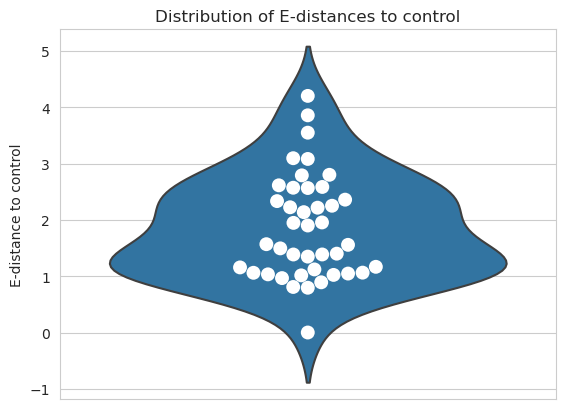

In [23]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['control'], inner=None)
    sns.swarmplot(data=estats.loc['control'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

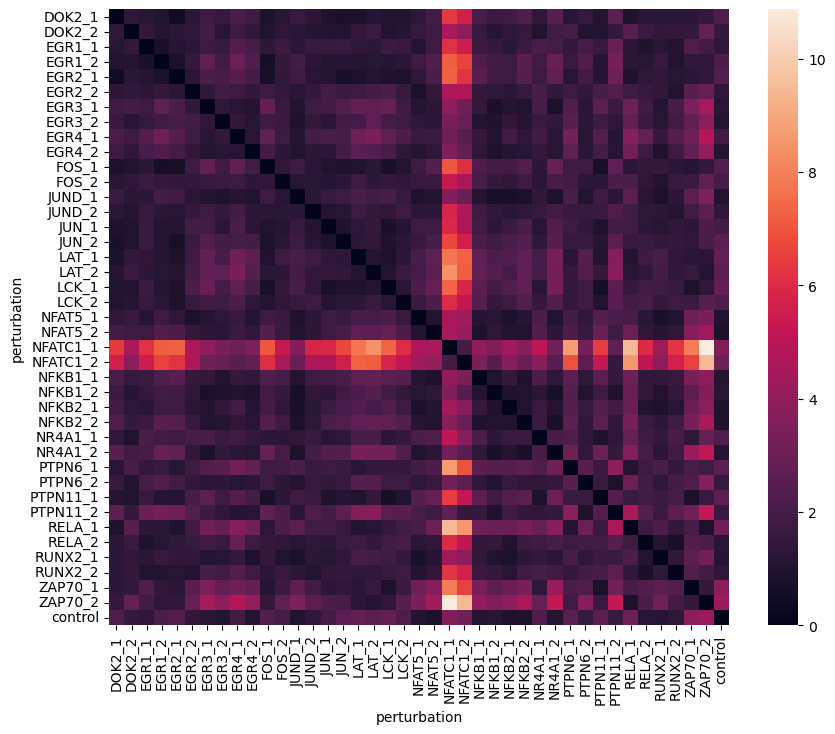

In [24]:
fig, ax = pl.subplots(1,1, figsize=[10,8])
order = estats.sort_index().index
sns.heatmap(estats.loc[order, order])
pl.show()

# E-testing

In [25]:
# e-testing (can be slow)
df = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', control='control', alpha=0.05, runs=1000)

100%|██████████| 1000/1000 [00:08<00:00, 118.92it/s]


In [26]:
df.head()

,edist,pvalue,significant,pvalue_adj,significant_adj
DOK2_1,2.185220,0.011,True,0.249927,False
DOK2_2,1.468166,0.173,False,0.977607,False
EGR1_1,1.361279,0.314,False,0.996600,False
EGR1_2,2.100216,0.018,True,0.353340,False
EGR2_1,2.318189,0.007,True,0.178554,False


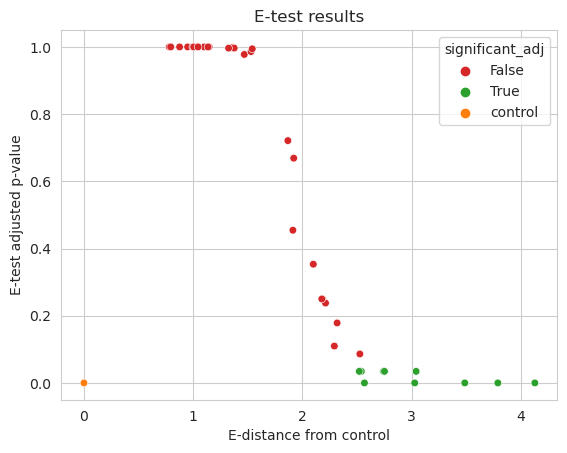

In [27]:
df.loc[df.index=='control', 'significant_adj'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test adjusted p-value')
pl.show()

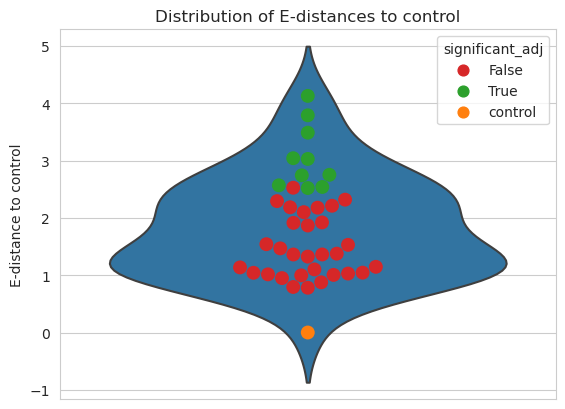

In [28]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=df, y='edist', inner=None)
    sns.swarmplot(data=df, x=[0]*len(df), y='edist', size=10, hue='significant_adj', dodge=False, palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'})
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()